In [13]:
import torch.nn.functional as F
import torch
import numpy as np
import struct
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
from pathlib import Path
import pickle
import gzip

In [6]:
"""initial path """
DATAPATH = Path("F:\DL\Mnist_data")
PATH = DATAPATH / "mnist"
FILENAME = "mnist.pkl.gz"

In [7]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

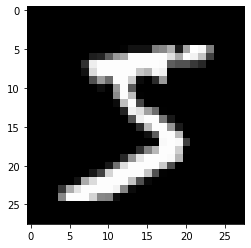

In [9]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")

In [11]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17048\3222872844.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))


In [15]:
loss_func = F.cross_entropy
def model(xb):
    return xb.mm(weights) + bias
bs = 64
xb = x_train[0:bs]
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype=torch.float, requires_grad=True)
bias = torch.zeros(10, requires_grad=True)
print(loss_func(model(xb), yb))

tensor(13.2200, grad_fn=<NllLossBackward0>)


In [18]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)  # 输入784, 特征h1: 128
        self.hidden2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):  # x a batch data
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [19]:
net = Mnist_NN()
print(net)
for name, parameter in net.named_parameters():
    print(name, parameter, parameter.size())

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
hidden1.weight Parameter containing:
tensor([[ 0.0208, -0.0306,  0.0193,  ...,  0.0043, -0.0280,  0.0326],
        [-0.0197, -0.0014,  0.0231,  ...,  0.0285,  0.0343,  0.0020],
        [ 0.0030,  0.0088,  0.0077,  ..., -0.0235, -0.0048, -0.0161],
        ...,
        [-0.0114, -0.0328,  0.0125,  ...,  0.0352,  0.0032,  0.0086],
        [ 0.0073,  0.0098,  0.0338,  ..., -0.0137,  0.0302, -0.0294],
        [ 0.0164,  0.0177, -0.0035,  ...,  0.0246, -0.0051,  0.0283]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-0.0096,  0.0018,  0.0323,  0.0357, -0.0073,  0.0152,  0.0167, -0.0114,
        -0.0286, -0.0206, -0.0327, -0.0344, -0.0016,  0.0067, -0.0239,  0.0129,
         0.0027, -0.0037,  0.0233,  

In [21]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs)

In [22]:
def get_data(train_ds, valid_dl, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs)
    )

In [27]:
# optimization :
def get_model():
    model = Mnist_NN()
    return model, optim.Adam(model.parameters(), lr=0.001)

In [36]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [37]:
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):  # steps is epoch.
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]) # 打包解包一一匹配为单个数据.
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print("currently step:"+str(step), "validate loss:"+str(val_loss))

In [40]:

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(5, model, loss_func, opt, train_dl, valid_dl)


currently step:0 validate loss:0.18235376028120517
currently step:1 validate loss:0.13997925418764354
currently step:2 validate loss:0.12318924208283424
currently step:3 validate loss:0.10824957657754421
currently step:4 validate loss:0.10309406057801097
